## Dowload Data 

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

"git" non è riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"ls" non è riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [ ]:
!ls pubmed-rct/PubMed_200k_RCT

dev.txt  test.txt  train.7z


In [ ]:
!pip install py7zr

In [ ]:
import py7zr
with py7zr.SevenZipFile('/content/pubmed-rct/PubMed_200k_RCT/train.7z', mode='r') as z:
    z.extractall(path="/content/pubmed-rct/PubMed_200k_RCT")

In [ ]:
data_dir = "pubmed-rct/PubMed_200k_RCT/"

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_200k_RCT/train.txt',
 'pubmed-rct/PubMed_200k_RCT/test.txt',
 'pubmed-rct/PubMed_200k_RCT/train.7z',
 'pubmed-rct/PubMed_200k_RCT/dev.txt']

## Preprocessing

In [ ]:
def get_lines(filename):
  
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

In [ ]:
def preprocess_text_with_line_numbers(filename):

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 4.5 s, sys: 1.19 s, total: 5.7 s
Wall time: 5.81 s


(2211861, 28932, 29493)

In [ ]:
train_samples[:3]

[{'target': 'BACKGROUND',
  'text': 'the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'line_number': 0,
  'total_lines': 10},
 {'target': 'BACKGROUND',
  'text': 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
  'line_number': 1,
  'total_lines': 10},
 {'target': 'METHODS',
  'text': 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
  'line_number': 2,
  'total_lines': 10}]

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10
5,METHODS,participants will access the program for a min...,5,10
6,METHODS,primary outcomes are domain specific self-effi...,6,10
7,METHODS,"secondary outcomes include : depression , anxi...",7,10
8,METHODS,"data collection will take place at baseline , ...",8,10
9,CONCLUSIONS,results of the positive outlook study will pro...,9,10


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: target, dtype: int64

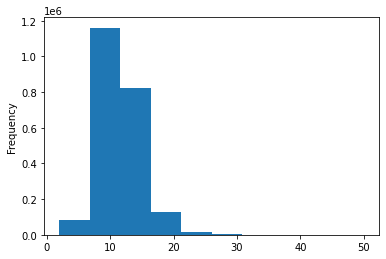

In [ ]:
train_df.total_lines.plot.hist();

### Stopword Removal

In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
import re
from nltk import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def remove_stopwords(text):
    removed = []
    tokens = word_tokenize(text)
    stop = set(stopwords.words("english"))
    for i in range(len(tokens)):
        if tokens[i] not in stop:
            removed.append(tokens[i])
    return " ".join(removed)

In [ ]:
train_df["text"] =  train_df["text"].apply(lambda x: remove_stopwords(x))
val_df["text"] =  val_df["text"].apply(lambda x: remove_stopwords(x))
test_df["text"] = test_df["text"].apply(lambda x: remove_stopwords(x))

In [ ]:
# Convert abstract text lines into lists 
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(2211861, 28932, 29493)

In [ ]:
train_sentences[:5]

['emergence hiv chronic condition means people living hiv required take responsibility self-management condition , including making physical , emotional social adjustments .',
 'paper describes design evaluation positive outlook , online program aiming enhance self-management skills gay men living hiv .',
 'study designed randomised controlled trial men living hiv australia assigned either intervention group usual care control group .',
 "intervention group participate online group program ` positive outlook ' .",
 'program based self-efficacy theory uses self-management approach enhance skills , confidence abilities manage psychosocial issues associated hiv daily life .']

In [ ]:
"""import pickle # Save Sentence variables

with open("/content/gdrive/MyDrive/Text Mining/Saved Models/train_sentences_NoStopWord", "wb") as fp:
  pickle.dump(train_sentences, fp)
with open("/content/gdrive/MyDrive/Text Mining/Saved Models/val_sentences_NoStopWord", "wb") as fp:
  pickle.dump(val_sentences, fp)
with open("/content/gdrive/MyDrive/Text Mining/Saved Models/test_sentences_NoStopWord", "wb") as fp:
  pickle.dump(test_sentences, fp)"""

In [ ]:
"""import pickle #load Sentence variables 
with open("C:\\Users\\kolys\\Università\\SecondoAnno\\Text Mining\\train_sentences_NoStopWord", "rb") as fp:
    train_sentences = pickle.load(fp)
    
with open("C:\\Users\\kolys\\Università\\SecondoAnno\\Text Mining\\val_sentences_NoStopWord", "rb") as fp:
    val_sentences = pickle.load(fp)
    
with open("C:\\Users\\kolys\\Università\\SecondoAnno\\Text Mining\\test_sentences_NoStopWord", "rb") as fp:
    test_sentences = pickle.load(fp)"""

## Preprocessing for Deep Learning Models

In [ ]:
import tensorflow as tf
from tensorflow import keras

print("Is GPU available: "tf.test.is_gpu_available())

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
print("Numbers of GPU: ", len(tf.config.experimental.list_physical_devices('GPU')))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
"""import pandas as pd ## RUN THIS CELL ONLY IF DON'T HAVE THE DATA FRAME 

train_df = pd.read_csv('C:\\Users\\kolys\\Università\\SecondoAnno\\Text Mining\\train_df')  
val_df = pd.read_csv('C:\\Users\\kolys\\Università\\SecondoAnno\\Text Mining\\val_df')
test_df = pd.read_csv('C:\\Users\\kolys\\Università\\SecondoAnno\\Text Mining\\test_df')"""

In [ ]:
# One hot encode labels
import sklearn
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

C:\Users\kolys\anaconda3\envs\TensorFlow\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [ ]:
# Extract labels ("target" columns) and encode them into integers 

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([0, 0, 2, ..., 4, 4, 4])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [ ]:
train_dataset = train_dataset.batch(256).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(256).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(256).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

## RNN Creation 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional, Reshape

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder") # Possibile implementazione di bert per gli embeddings

### LSTM

In [ ]:
input = layers.Input(shape=(), dtype=tf.string)
x = tf_hub_embedding_layer(input)
x = Reshape((-1, 512))(x)
x = SpatialDropout1D(0.2)(x)
x = LSTM(128, return_sequences=True)(x)
x = LSTM(128, return_sequences=False)(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model_2 = tf.keras.Model(inputs=input,
                        outputs=output)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
reshape (Reshape)            (None, 1, 512)            0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1, 512)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 128)            328192    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0     

In [ ]:
from IPython.display import clear_output

class TrainingPlot(keras.callbacks.Callback):

    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        clear_output(wait=True)
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))

        N = np.arange(0, len(self.losses))
        
        # Plot train loss, train acc, val loss and val acc against epochs passed
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        ax1.plot(N, self.losses, label = "train_loss")
        ax2.plot(N, self.acc, label = "train_acc")
        ax1.plot(N, self.val_losses, label = "val_loss")
        ax2.plot(N, self.val_acc, label = "val_acc")
        ax1.set_title("Loss")
        ax2.set_title("Accuracy")
        ax1.set(xlabel='Epoch', ylabel='Loss')
        ax2.set(xlabel='Epoch', ylabel='Acc')
        fig.tight_layout()
        ax1.legend()
        ax2.legend()
        # plt.savefig('output/Epoch-{}.png'.format(epoch))
        plt.show()
        
training_history = TrainingPlot()

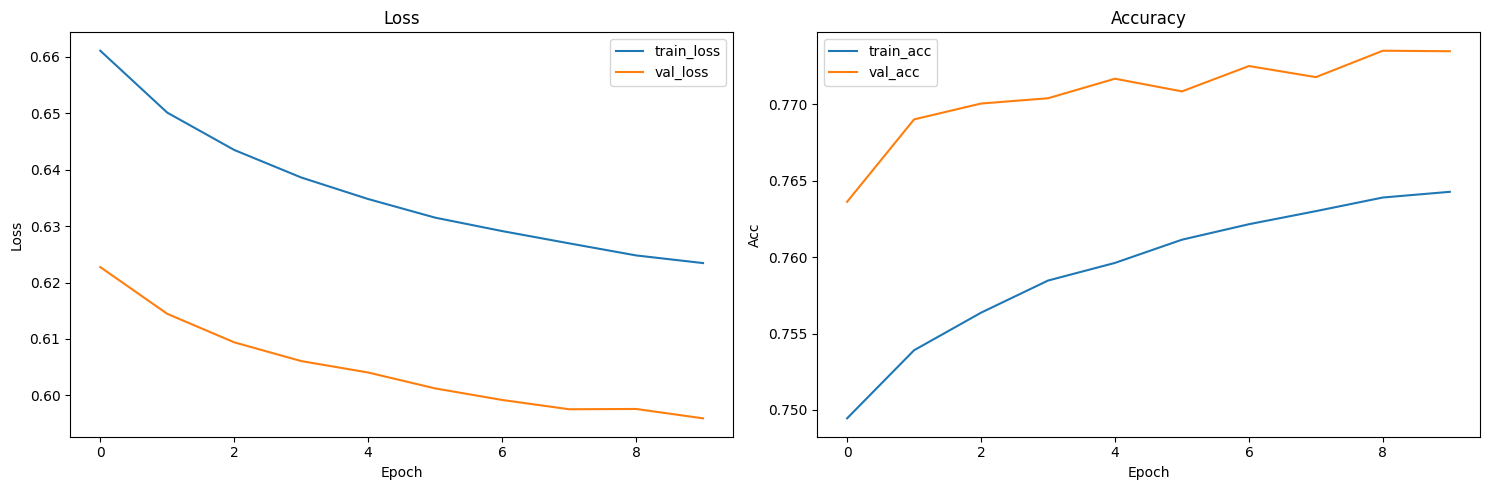

In [ ]:
model_2.fit(train_dataset,
            epochs=10,
            validation_data=valid_dataset,
            callbacks = [training_history]
            )

In [ ]:
model_2.save('C:\\Users\\kolys\\Università\\SecondoAnno\\Text Mining\\LSTM_Model_NO_StopWords')

INFO:tensorflow:Assets written to: C:\Users\kolys\Università\SecondoAnno\Text Mining\LSTM_Model_NO_StopWords\assets


INFO:tensorflow:Assets written to: C:\Users\kolys\Università\SecondoAnno\Text Mining\LSTM_Model_NO_StopWords\assets


In [ ]:
from sklearn.metrics import accuracy_score

Y_test_pred = model_2.predict(test_sentences)
y_test_pred = Y_test_pred.argmax(1)
print(accuracy_score(test_labels_encoded, y_test_pred))

0.7782524666870104


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_encoded, y_test_pred))

              precision    recall  f1-score   support

           0       0.56      0.50      0.53      2663
           1       0.67      0.65      0.66      4426
           2       0.84      0.88      0.86      9751
           3       0.68      0.54      0.61      2377
           4       0.84      0.86      0.85     10276

    accuracy                           0.78     29493
   macro avg       0.72      0.69      0.70     29493
weighted avg       0.77      0.78      0.77     29493



### Bi-LSTM

In [ ]:
input = layers.Input(shape=(), dtype=tf.string)
x = tf_hub_embedding_layer(input)
x = Reshape((-1, 512))(x)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Bidirectional(LSTM(128, return_sequences=False))(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model_3 = tf.keras.Model(inputs=input,
                        outputs=output)

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_3.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 512)            0         
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1, 512)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1, 256)            656384    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0   

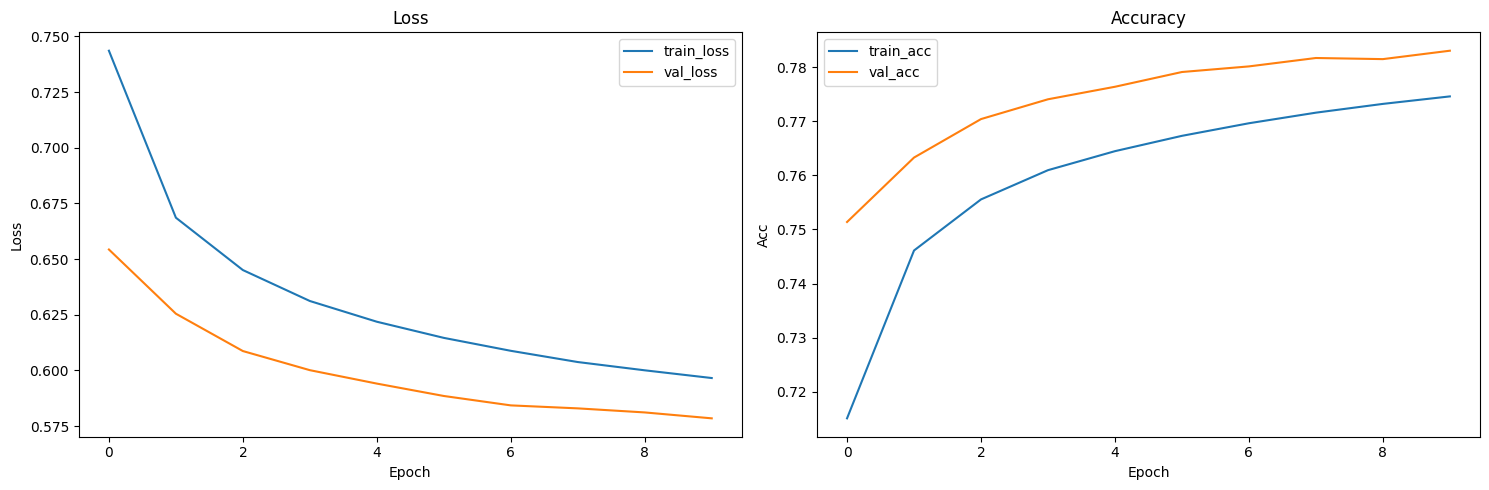

In [ ]:
model_3.fit(train_dataset,
            epochs=10,
            validation_data=valid_dataset,
            callbacks = [training_history]
            )

In [ ]:
from sklearn.metrics import accuracy_score

Y_test_pred = model_3.predict(test_sentences)
y_test_pred = Y_test_pred.argmax(1)
print(accuracy_score(test_labels_encoded, y_test_pred))

0.7842538907537382


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_encoded, y_test_pred))

              precision    recall  f1-score   support

           0       0.57      0.54      0.55      2663
           1       0.69      0.65      0.67      4426
           2       0.83      0.89      0.86      9751
           3       0.70      0.54      0.61      2377
           4       0.84      0.86      0.85     10276

    accuracy                           0.78     29493
   macro avg       0.73      0.70      0.71     29493
weighted avg       0.78      0.78      0.78     29493



In [ ]:
model_3.save('C:\\Users\\kolys\\Università\\SecondoAnno\\Text Mining\\Bi-LSTM_Model')

INFO:tensorflow:Assets written to: C:\Users\kolys\Università\SecondoAnno\Text Mining\Bi-LSTM_Model\assets


INFO:tensorflow:Assets written to: C:\Users\kolys\Università\SecondoAnno\Text Mining\Bi-LSTM_Model\assets


### GRU

In [ ]:
input = layers.Input(shape=(), dtype=tf.string)
x = tf_hub_embedding_layer(input)
x = Reshape((-1, 512))(x)
x = SpatialDropout1D(0.2)(x)
x = GRU(128, return_sequences=True)(x)
x = GRU(128, return_sequences=False)(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model_4 = tf.keras.Model(inputs=input,
                        outputs=output)

# Compile the model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 reshape_3 (Reshape)         (None, 1, 512)            0         
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 1, 512)           0         
 lDropout1D)                                                     
                                                                 
 gru (GRU)                   (None, 1, 128)            246528    
                                                                 
 gru_1 (GRU)                 (None, 128)               9907

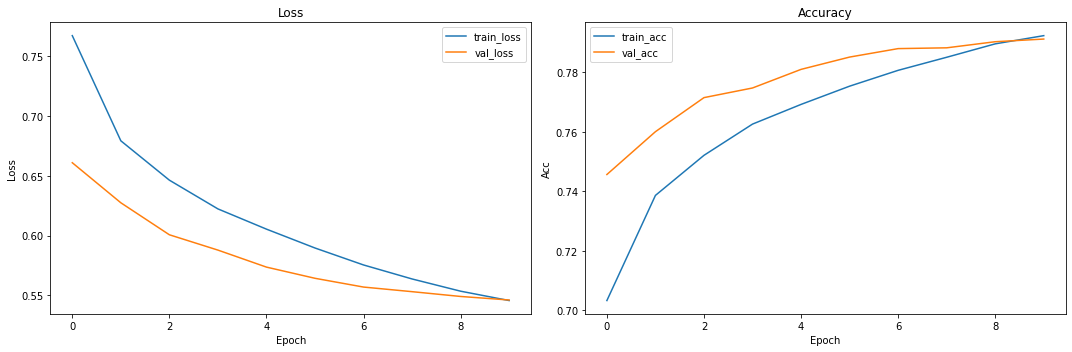

2814/2814 [==============================] - 53s 19ms/step - loss: 0.5456 - accuracy: 0.7924 - val_loss: 0.5460 - val_accuracy: 0.7912


In [ ]:
model_4.fit(train_dataset,
            epochs=10,
            validation_data=valid_dataset,
            callbacks = [training_history]
            )

In [ ]:
from sklearn.metrics import accuracy_score

Y_test_pred = model_4.predict(test_sentences)
y_test_pred = Y_test_pred.argmax(1)
print(accuracy_score(test_labels_encoded, y_test_pred))

942/942 [==============================] - 11s 11ms/step
0.7867927658868425


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_encoded, y_test_pred))

              precision    recall  f1-score   support

           0       0.62      0.64      0.63      3621
           1       0.68      0.70      0.69      4571
           2       0.86      0.87      0.86      9897
           3       0.73      0.47      0.57      2333
           4       0.84      0.87      0.85      9713

    accuracy                           0.79     30135
   macro avg       0.74      0.71      0.72     30135
weighted avg       0.79      0.79      0.78     30135



In [ ]:
model_4.save('/content/gdrive/MyDrive/Text Mining/Saved Models/GRU_Model')